# Amazon Review Analysis
In the following notebook, which is a part of the 4 part assignment, we will be implementing a model which does a sentiment analysis on a dataset using a 3 Hidden Layer Neural Network with Bag of Words and Random Search.

For the following we will be doing the following things:
1. Data Preprocessing
2. Making Data Machine Undersdtandable
3. Neural network with Random Search
4. Evaluation and Plotting Graph

## Data Pre-processing


In [ ]:
# Data Preprocessing
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split


# Download required NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/Machine Learning for Finances/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Machine Learning for Finances/test.csv')

# Function to clean text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words and lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply the clean_text function to the reviewText column
train_df['cleanedText'] = train_df['reviewText'].apply(clean_text)
test_df['cleanedText'] = test_df['reviewText'].apply(clean_text)

# Separate features and target
X_train = train_df['cleanedText']
y_train = train_df['Positive']
X_test = test_df['cleanedText']
y_test = test_df['Positive']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Making Data Machine Understandable

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## Neural Network with Random Search


In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [ ]:
# Convert data to PyTorch tensors
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network
class ReviewClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3):
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Hyperparameter search space
param_grid = {
    'hidden_size1': [128, 256, 512],
    'hidden_size2': [64, 128, 256],
    'hidden_size3': [32, 64, 128],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64, 128]
}

In [ ]:
# Random search
def random_search(param_grid, num_iters):
    best_acc = 0
    best_params = None

    for _ in range(num_iters):
        params = {key: random.choice(values) for key, values in param_grid.items()}
        input_size = 5000  # Number of features
        model = ReviewClassifier(input_size, params['hidden_size1'], params['hidden_size2'], params['hidden_size3'])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        train_dataset = torch.utils.data.TensorDataset(X_train_tfidf, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

        num_epochs = 10

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tfidf)
            predictions = (predictions > 0.5).float()
            accuracy = accuracy_score(y_test, predictions)

        if accuracy > best_acc:
            best_acc = accuracy
            best_params = params
            best_model = model

        print(f"Params: {params}, Accuracy: {accuracy:.4f}")

    print(f"Best Params: {best_params}, Best Accuracy: {best_acc:.4f}")
    return best_model, best_params

# Perform random search
best_model, best_params = random_search(param_grid, num_iters=20)

# Evaluate the best model
best_model.eval()
with torch.no_grad():
    predictions = best_model(X_test_tfidf)
    predictions = (predictions > 0.5).float()
    accuracy = accuracy_score(y_test, predictions)
    print(f"Best Model Test Accuracy: {accuracy:.4f}")

Params: {'hidden_size1': 512, 'hidden_size2': 128, 'hidden_size3': 32, 'learning_rate': 0.001, 'batch_size': 32}, Accuracy: 0.8758
Params: {'hidden_size1': 128, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_rate': 0.01, 'batch_size': 64}, Accuracy: 0.8705
Params: {'hidden_size1': 256, 'hidden_size2': 256, 'hidden_size3': 64, 'learning_rate': 0.01, 'batch_size': 64}, Accuracy: 0.8752
Params: {'hidden_size1': 128, 'hidden_size2': 64, 'hidden_size3': 64, 'learning_rate': 0.001, 'batch_size': 128}, Accuracy: 0.8702
Params: {'hidden_size1': 128, 'hidden_size2': 256, 'hidden_size3': 128, 'learning_rate': 0.01, 'batch_size': 128}, Accuracy: 0.8778
Params: {'hidden_size1': 128, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_rate': 0.001, 'batch_size': 64}, Accuracy: 0.8732
Params: {'hidden_size1': 256, 'hidden_size2': 128, 'hidden_size3': 128, 'learning_rate': 0.001, 'batch_size': 32}, Accuracy: 0.8802
Params: {'hidden_size1': 512, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_ra

## Evaluation and Plotting Graph


In [ ]:
from sklearn.metrics import f1_score, classification_report

# Predict and evaluate the model
f1 = f1_score(y_test, predictions)
print(f"Best Model Test F1 Score: {f1:.4f}")
report = classification_report(y_test, predictions)
print(f"Classification Report:\n{report}")

Best Model Test F1 Score: 0.9256
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       958
         1.0       0.92      0.93      0.93      3042

    accuracy                           0.89      4000
   macro avg       0.85      0.84      0.84      4000
weighted avg       0.89      0.89      0.89      4000



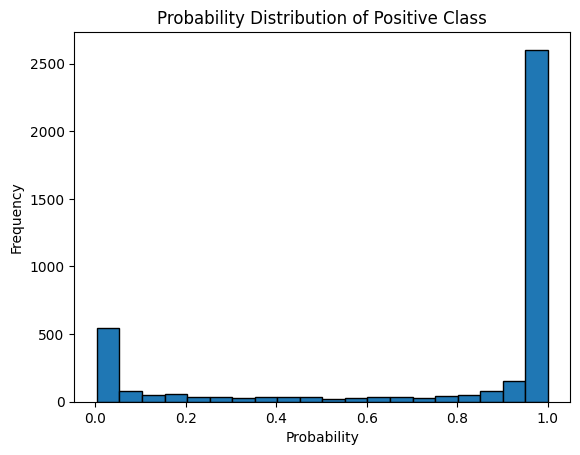

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram of probabilities for the positive class
probabilities = best_model(X_test_tfidf)
plt.hist(probabilities.detach().numpy(), bins=20, edgecolor='k')
plt.title('Probability Distribution of Positive Class')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Print optimized hyperparameters
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'hidden_size1': 512, 'hidden_size2': 64, 'hidden_size3': 64, 'learning_rate': 0.0001, 'batch_size': 128}
